In [51]:
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

# Correlogram Plot
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

# Unit Root Test
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

In [100]:
# Download data and test unit root
data = pd.read_csv('Data.csv')
data = data.drop(['Date'], axis=1)
date_range = pd.date_range(start="1/1997", end="07/2020", freq='M')
data.index = date_range
data = data[['tot','tnt','mon','res','beer']]
test_unit_root(data)

,p-value
tot,0.07%
tnt,13.31%
mon,99.87%
res,68.38%
beer,78.39%


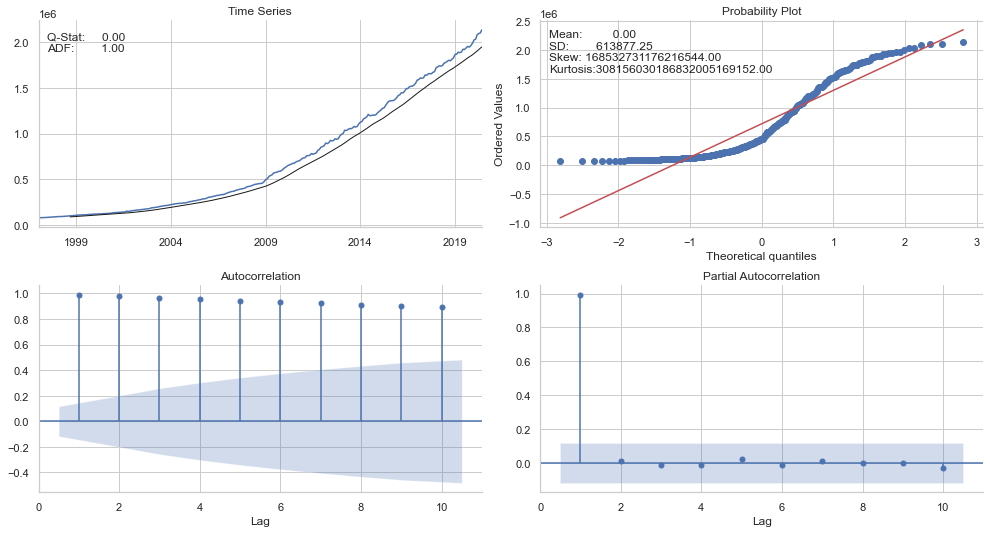

In [101]:
plot_correlogram(data.mon)

In [103]:
# transform the data and make all the series are stationary
import numpy as np 
df_tran = pd.DataFrame(
    {'tnt': data.tnt.diff(1),
      'mon': np.log(data.mon).diff(1).diff(12),
      'res': np.log(data.res).diff(1).diff(12),
      'beer': data.beer.diff(1)
      }
).dropna()
test_unit_root(df_tran)
df_tran['tot'] = data['tot']['1998-02-28':]
test_unit_root(df_tran)

,p-value
tnt,0.00%
mon,0.01%
res,0.29%
beer,0.00%
tot,0.15%


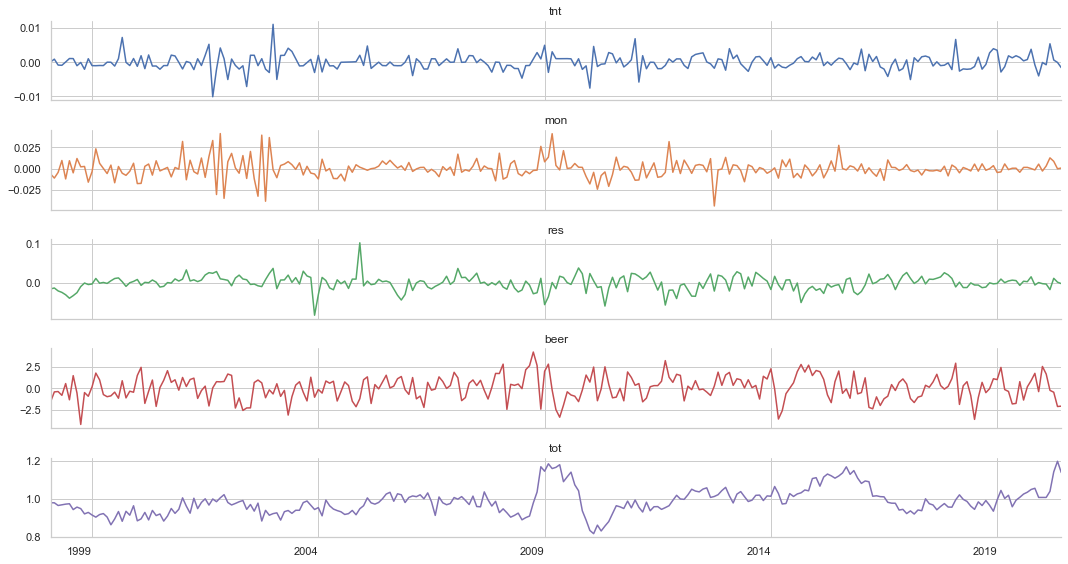

In [108]:
df_tran.plot(
    subplots=True,
    title=['tnt','mon','res','beer','tot'],
    legend=False,
    rot=0,
    figsize=(15,8)
)
sns.despine()
plt.tight_layout()

In [118]:
# VAR
from statsmodels.tsa.api import VAR
model_var = VAR(df_tran)

model = model_var.select_order(13)
model.summary()  


,AIC,BIC,FPE,HQIC
0,-33.97,-33.90,1.762e-15,-33.94
1,-35.67*,-35.25*,3.231e-16*,-35.50*
2,-35.61,-34.85,3.413e-16,-35.31
3,-35.60,-34.49,3.455e-16,-35.16
4,-35.61,-34.16,3.425e-16,-35.03
5,-35.52,-33.72,3.748e-16,-34.80
6,-35.48,-33.33,3.924e-16,-34.62
7,-35.43,-32.94,4.143e-16,-34.43
8,-35.35,-32.51,4.507e-16,-34.21
9,-35.29,-32.11,4.806e-16,-34.01


In [125]:
# the suggested order is 1
var_results = model_var.fit(maxlags=1, ic='aic')
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Oct, 2020
Time:                     15:21:22
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -35.3007
Nobs:                     268.000    HQIC:                  -35.5412
Log likelihood:           2912.78    FPE:                3.12291e-16
AIC:                     -35.7026    Det(Omega_mle):     2.79564e-16
--------------------------------------------------------------------
Results for equation tnt
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.001662         0.002121           -0.784           0.433
L1.tnt         -0.141225         0.061422           -2.299           0.021
L1.mon          0.016033         0.012824            1.250           0.211
L1.res     

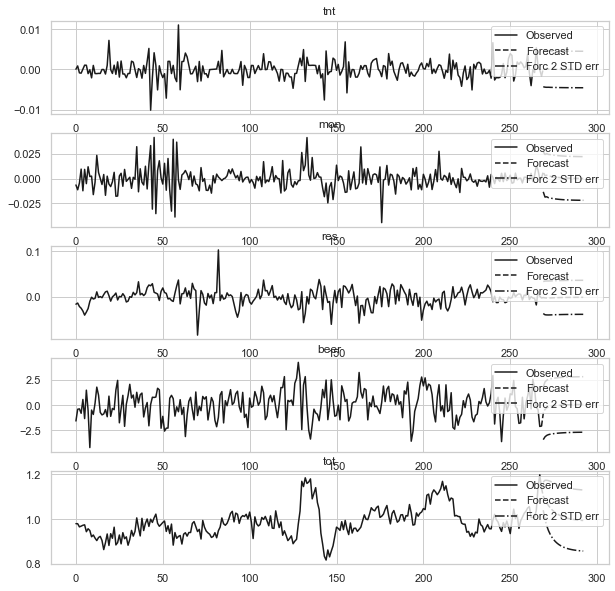

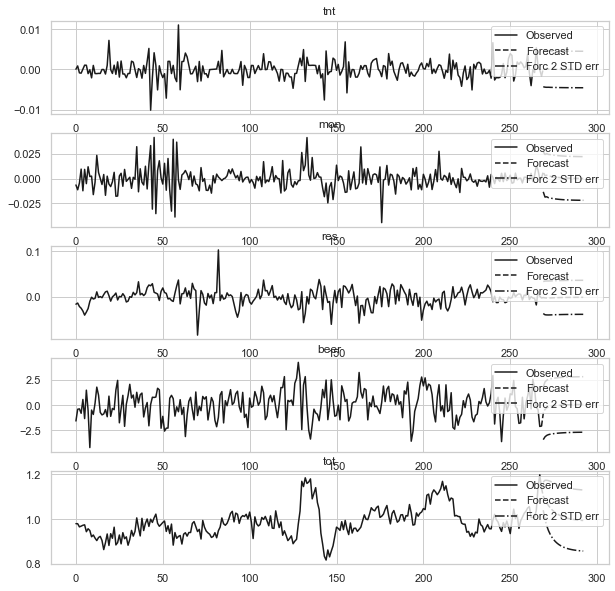

In [126]:
var_results.plot_forecast(24)

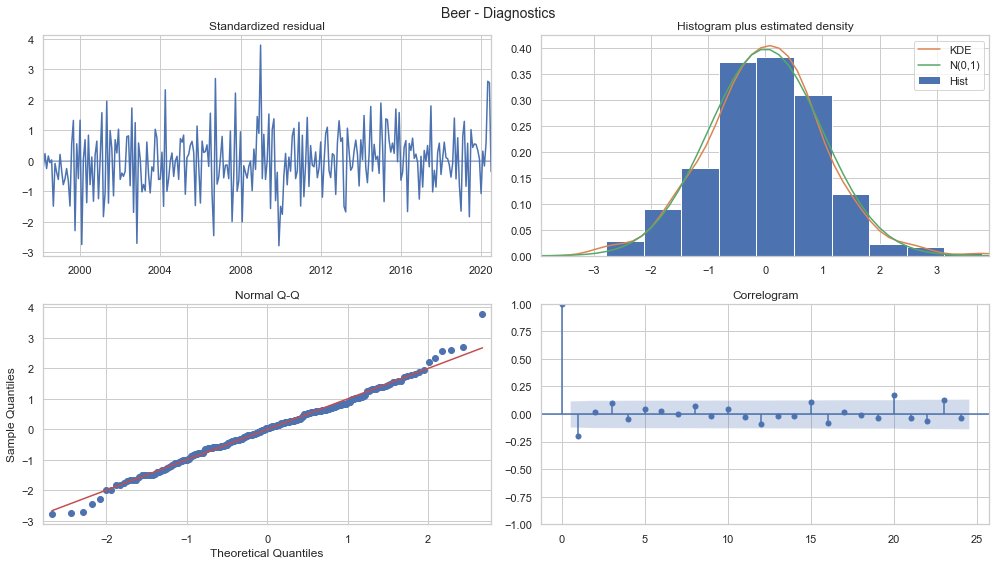

In [121]:
# Plot Diagnostics
model.plot_diagnostics(variable=4, figsize=(14,8), lags=24)
plt.gcf().suptitle('Beer - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

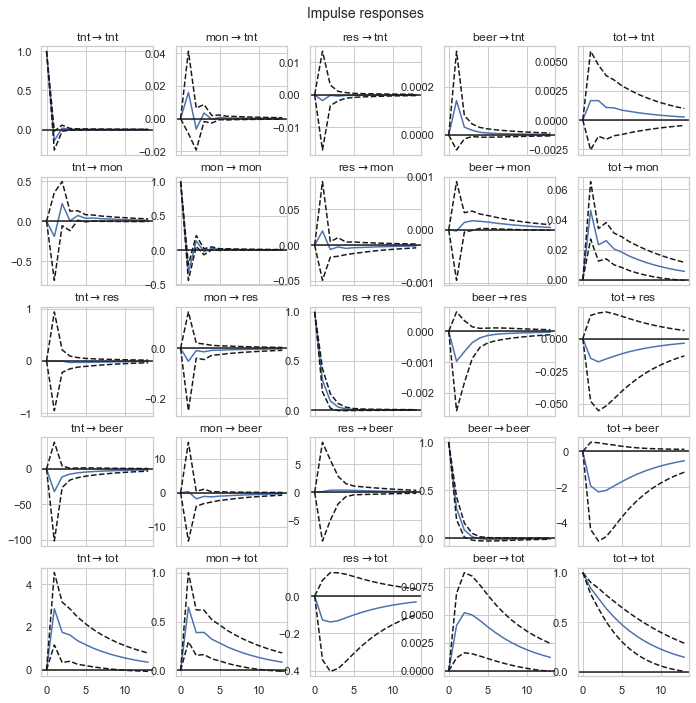

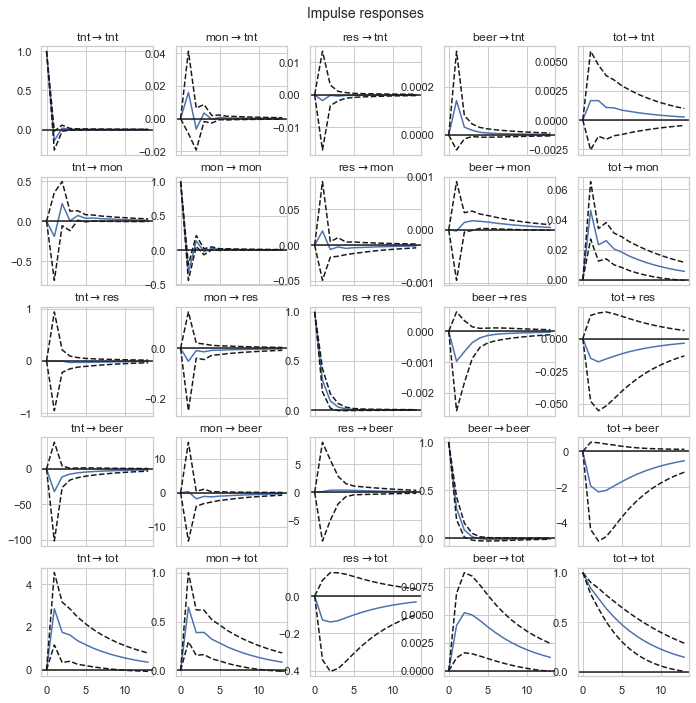

In [128]:
# Impulse Response Analysis
irf = var_results.irf(13)
irf.plot(orth=False)

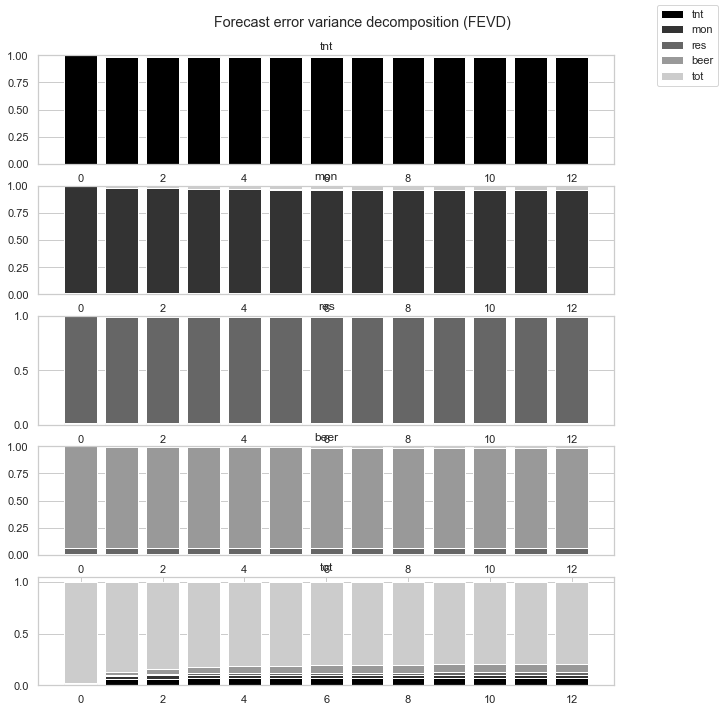

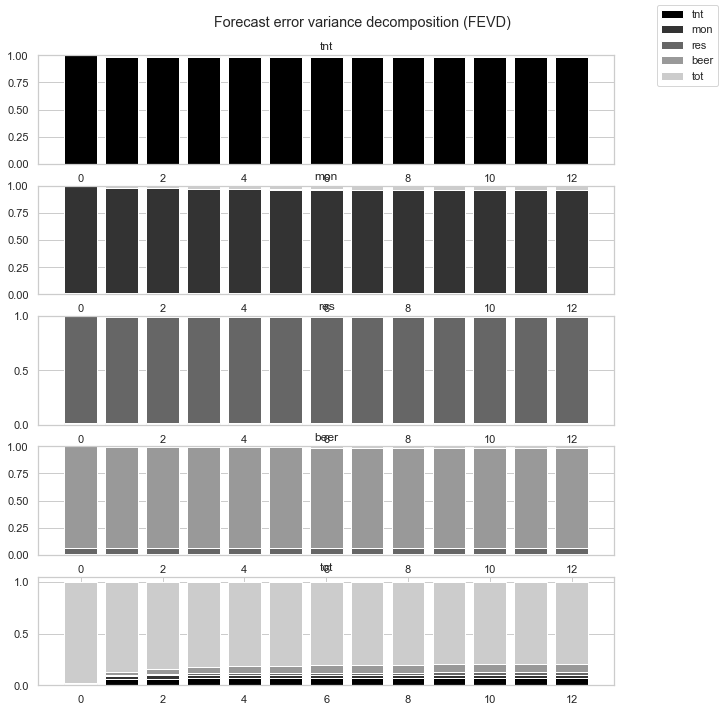

In [129]:
# Forecast Error Variance Decomposition
var_results.fevd(13).plot()

In [132]:
# VARMAX
model = VARMAX(df_tran, order=(1,0), trend='c').fit(maxiter=1000)
model.summary() 

Dep. Variable:,"['tnt', 'mon', 'res', 'beer', 'tot']",No. Observations:,269
Model:,VAR(1),Log Likelihood,2923.552
,+ intercept,AIC,-5757.103
Date:,"Sun, 11 Oct 2020",BIC,-5595.341
Time:,15:26:15,HQIC,-5692.140
Sample:,02-28-1998,,
,- 06-30-2020,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.66, 89.83, 111.71, 77.21, 59.28",Jarque-Bera (JB):,"115.29, 127.63, 295.03, 12.88, 5.95"
Prob(Q):,"0.00, 0.00, 0.00, 0.00, 0.03",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.05"
Heteroskedasticity (H):,"0.64, 0.29, 0.54, 1.02, 0.87",Skew:,"0.28, 0.55, -0.24, -0.53, 0.10"


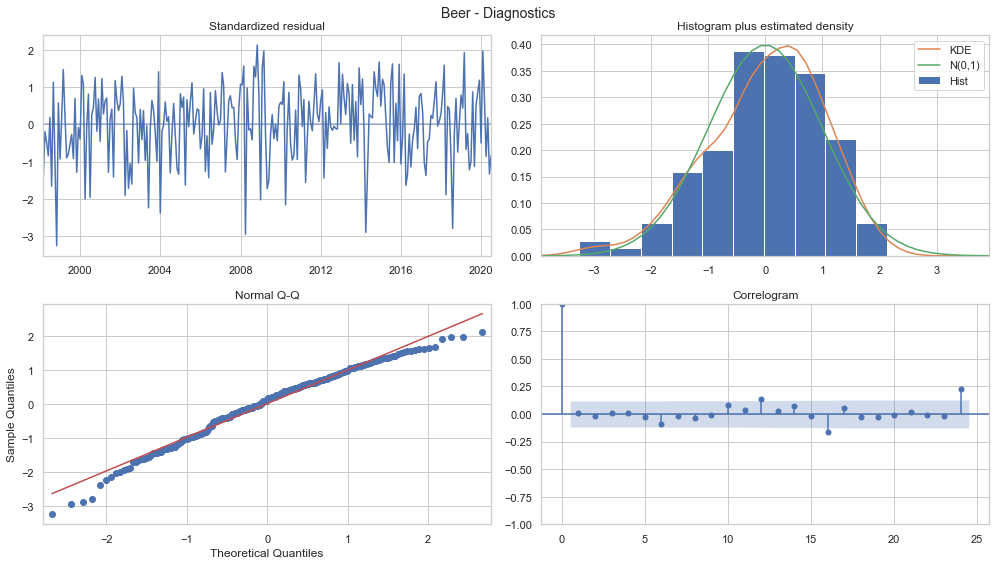

In [135]:
model.plot_diagnostics(variable=3, figsize=(14,8), lags=24)
plt.gcf().suptitle('Beer - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

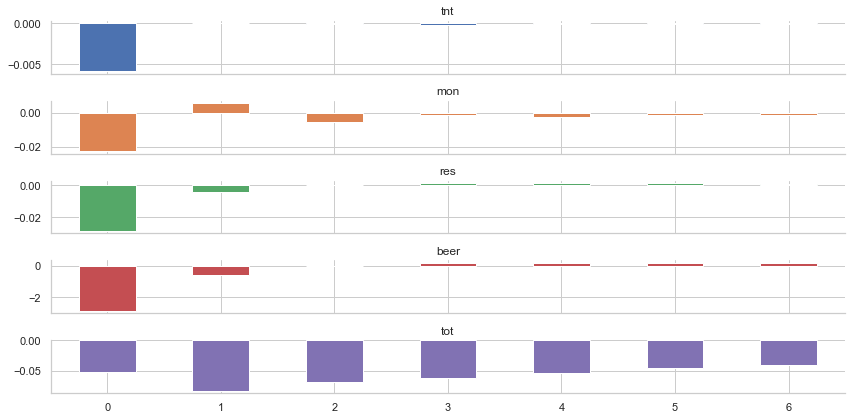

In [137]:
# Impulse-Response Function
changes = df_tran.diff().quantile(.05).tolist()  # quantile=0.01 means negative change
# print (changes)
model.impulse_responses(steps=6,
                        impulse=changes).plot.bar(subplots=True,
                                                  figsize=(12, 6),
                                                  rot=0,
                                                  legend=False)
sns.despine()
plt.tight_layout()

In [138]:
# Prediction
pred_steps = 12
length_of_data =len(df_tran)
start = length_of_data - pred_steps

preds = model.predict(start=start+1, end=length_of_data)

In [139]:
predict = df_tran[:start]
predict = pd.concat([predict, preds])
predict.index = df_tran.index

predict.head()

,tnt,mon,res,beer,tot
1998-02-28,0.000075,-0.006475,-0.016031,-1.58,0.979228
1998-03-31,0.000882,-0.011313,-0.013628,-0.42,0.979063
1998-04-30,-0.000845,-0.004555,-0.021137,-0.38,0.965000
1998-05-31,-0.000914,0.009543,-0.024904,-0.82,0.968270
1998-06-30,0.000054,-0.012327,-0.031034,0.55,0.972112


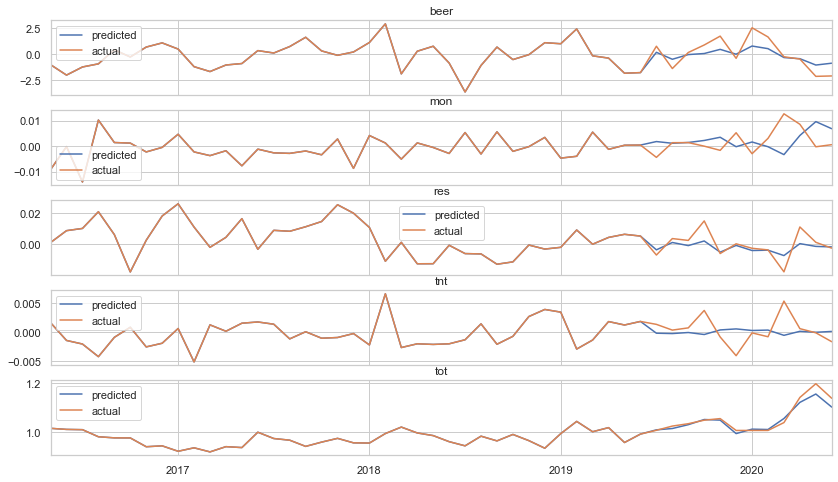

In [146]:
begin = -50

fig, axes = plt.subplots(nrows=5, figsize=(14, 8), sharex=True)

predict.beer[begin:].plot(label='predicted', ax=axes[0], title='beer')
df_tran.beer[begin:].plot(ax=axes[0], label='actual')
axes[0].legend()

predict.mon[begin:].plot(label='predicted', ax=axes[1], title='mon')
df_tran.mon[begin:].plot(ax=axes[1], label='actual')
axes[1].legend()

predict.res[begin:].plot(label='predicted', ax=axes[2], title='res')
df_tran.res[begin:].plot(ax=axes[2], label='actual')
axes[2].legend()

predict.tnt[begin:].plot(label='predicted', ax=axes[3], title='tnt')
df_tran.tnt[begin:].plot(ax=axes[3], label='actual')
axes[3].legend()

predict.tot[begin:].plot(label='predicted', ax=axes[4], title='tot')
df_tran.tot[begin:].plot(ax=axes[4], label='actual')
axes[4].legend()